# Feature Engineering and Modelling

---

1. Import packages
2. Load data
3. Modelling

---

## 1. Import packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os, sys
import optuna
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import tqdm as notebook_tqdm
from IPython.display import display

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

sys.path.append('../src')
from utils import save_plot
from models import ChurnPredictor, LightGBMChurnPredictor
%matplotlib inline

# Set plot style
sns.set_color_codes('deep')
sns.set_theme(style='whitegrid', context='notebook')

#plot presets
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

---
## 2. Load data

In [3]:
df = pd.read_csv('/home/zahemen/projects/BCGX---Customer-Churn-Analysis/data/data_for_predictions.csv')
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()

id  cons_12m  cons_gas_12m  cons_last_month  \
0  24011ae4ebbe3035111d65fa7c15bc57  0.000000      4.739944         0.000000   
1  d29c2c54acc38ff3c0614d0a653813dd  3.668479      0.000000         0.000000   
2  764c75f661154dac3a6c254cd082ea7d  2.736397      0.000000         0.000000   
3  bba03439a292a1e166f80264c16191cb  3.200029      0.000000         0.000000   
4  149d57cf92fc41cf94415803a877cb4b  3.646011      0.000000         2.721811   

   forecast_cons_12m  forecast_discount_energy  forecast_meter_rent_12m  \
0           0.000000                       0.0                 0.444045   
1           2.280920                       0.0                 1.237292   
2           1.689841                       0.0                 1.599009   
3           2.382089                       0.0                 1.318689   
4           2.650065                       0.0                 2.122969   

   forecast_price_energy_off_peak  forecast_price_energy_peak  \
0                        0.114481                    0.098142   
1                        0.145711                    0.000000   
2                        0.165794                    0.087899   
3                        0.146694                    0.000000   
4                        0.116900                    0.100015   

   forecast_price_pow_off_peak  ...  months_modif_prod  months_renewal  \
0                    40.606701  ...                  2               6   
1                    44.311378  ...                 76               4   
2                    44.311378  ...                 68               8   
3                    44.311378  ...                 69               9   
4                    40.606701  ...                 71               9   

   channel_MISSING  channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
0                0                                         0   
1                1                                         0   
2                0                                         0   
3                0                                         0   
4                1                                         0   

   channel_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                         1   
1                                         0   
2                                         1   
3                                         0   
4                                         0   

   channel_lmkebamcaaclubfxadlmueccxoimlema  \
0                                         0   
1                                         0   
2                                         0   
3                                         1   
4                                         0   

   channel_usilxuppasemubllopkaafesmlibmsdf  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws  \
0                                           0   
1                                           1   
2                                           1   
3                                           1   
4                                           1   

   origin_up_ldkssxwpmemidmecebumciepifcamkci  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   origin_up_lxidpiddsbxsbosboudacockeimpuepw  
0                                           1  
1                                           0  
2                                           0  
3                                           0  
4                                           0  

[5 rows x 63 columns]

In [4]:
df.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 63 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   id                                          14606 non-null  object 
 1   cons_12m                                    14606 non-null  float64
 2   cons_gas_12m                                14606 non-null  float64
 3   cons_last_month                             14606 non-null  float64
 4   forecast_cons_12m                           14606 non-null  float64
 5   forecast_discount_energy                    14606 non-null  float64
 6   forecast_meter_rent_12m                     14606 non-null  float64
 7   forecast_price_energy_off_peak              14606 non-null  float64
 8   forecast_price_energy_peak                  14606 non-null  float64
 9   forecast_price_pow_off_peak                 14606 non-null  float64
 10  has_gas   

---

## 3. Modelling

We now have a dataset containing features that we have engineered and we are ready to start training a predictive model. Remember, we only need to focus on training a `Random Forest` classifier.

### Data sampling

The first thing we want to do is split our dataset into training and test samples. The reason why we do this, is so that we can simulate a real life situation by generating predictions for our test sample, without showing the predictive model these data points. This gives us the ability to see how well our model is able to generalise to new data, which is critical.

A typical % to dedicate to testing is between 20-30, for this example we will use a 75-25% split between train and test respectively.

In [5]:
# Make a copy of our data
train_df = df.copy(deep='True')

# Separate target variable from independent variables
y = df['churn']
X = df.drop(columns=['id', 'churn'])
print(X.shape)
print(y.shape)

(14606, 61)
(14606,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10954, 61)
(10954,)
(3652, 61)
(3652,)


### Model training


In [7]:
# Add model training in here!
model_params = dict(
    n_estimators = 100, max_depth = 4, n_jobs = -1, random_state = 1234
)
baseline_model = RandomForestClassifier(**model_params) # Add parameters to the model!
baseline_model.fit(X_train, y_train) # Complete this method call!

RandomForestClassifier(max_depth=4, n_jobs=-1, random_state=1234)

### Evaluation

Now let's evaluate how well this trained model is able to predict the values of the test dataset.

In [8]:
y_pred = baseline_model.predict(X_test)
report = classification_report(y_test, y_pred)
print("Classification Report:\n")

print(report)

Classification Report:

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      3286
           1       0.00      0.00      0.00       366

    accuracy                           0.90      3652
   macro avg       0.45      0.50      0.47      3652
weighted avg       0.81      0.90      0.85      3652



---
### Baseline Random Forest (RF) Model with Basic Presets

- Accuracy: 90%
- Precision: 0.90 (for class 0), 0.00 (for class 1)
- Recall: 1.00 (for class 0), 0.00 (for class 1)
- F1-score: 0.95 (for class 0), 0.00 (for class 1)

**Interpretation:**

The baseline model has a high accuracy (90%), which might seem good at first glance, but the performance for class 1 is extremely poor. The model has an F1-score of 0.00 for class 1, which means it is unable to correctly identify positive samples at all.
This suggests a severe class imbalance problem, where the model is biased towards predicting the majority class (class 0) and completely fails at detecting class 1.

## Improved model with `RandomForest` and `SMOTE`
---

In [9]:
predictor_0 = ChurnPredictor(n_estimators=100, test_size=0.25)

# Train model (automatically handles data splitting and preprocessing)
cv_results = predictor_0.train(df)

In [10]:
cv_results

{'accuracy_mean': 0.8995797669586457,
 'accuracy_std': 0.0031848295509911665,
 'precision_mean': 0.43352112150718874,
 'precision_std': 0.06341567917089574,
 'recall_mean': 0.12027194614226237,
 'recall_std': 0.029094605961256587,
 'f1_mean': 0.18785546878058534,
 'f1_std': 0.04131898004366953,
 'roc_auc_mean': 0.6576341797150175,
 'roc_auc_std': 0.01903301977973243}

In [11]:

# Evaluate model on test set
test_results = predictor_0.evaluate()

print("\nClassification Report:")
print(pd.DataFrame(test_results['classification_report']).transpose())

print("\nConfusion Matrix:")
print(np.array(test_results['confusion_matrix']))

print(f"\nROC-AUC Score: {test_results['roc_auc']:.3f}")

print("\nClass Distribution:")
print("Original Training Set:", test_results['class_distribution']['train_original'])
print("Resampled Training Set:", test_results['class_distribution']['train_resampled'])
print("Test Set:", test_results['class_distribution']['test'])

print("\nTop 5 Most Important Features:")
for feature in test_results['feature_importance'][:5]:
    print(f"{feature['feature']}: {feature['importance']:.4f}")


Classification Report:
              precision    recall  f1-score      support
0              0.915259  0.986048  0.949336  3297.000000
1              0.540000  0.152113  0.237363   355.000000
accuracy       0.904984  0.904984  0.904984     0.904984
macro avg      0.727630  0.569080  0.593349  3652.000000
weighted avg   0.878781  0.904984  0.880127  3652.000000

Confusion Matrix:
[[3251   46]
 [ 301   54]]

ROC-AUC Score: 0.689

Class Distribution:
Original Training Set: {0: 9890, 1: 1064}
Resampled Training Set: {0: 9890, 1: 9890}
Test Set: {0: 3297, 1: 355}

Top 5 Most Important Features:
offpeak_diff_dec_january_power: 0.0459
pow_max: 0.0447
var_year_price_off_peak: 0.0417
tenure: 0.0369
margin_net_pow_ele: 0.0369


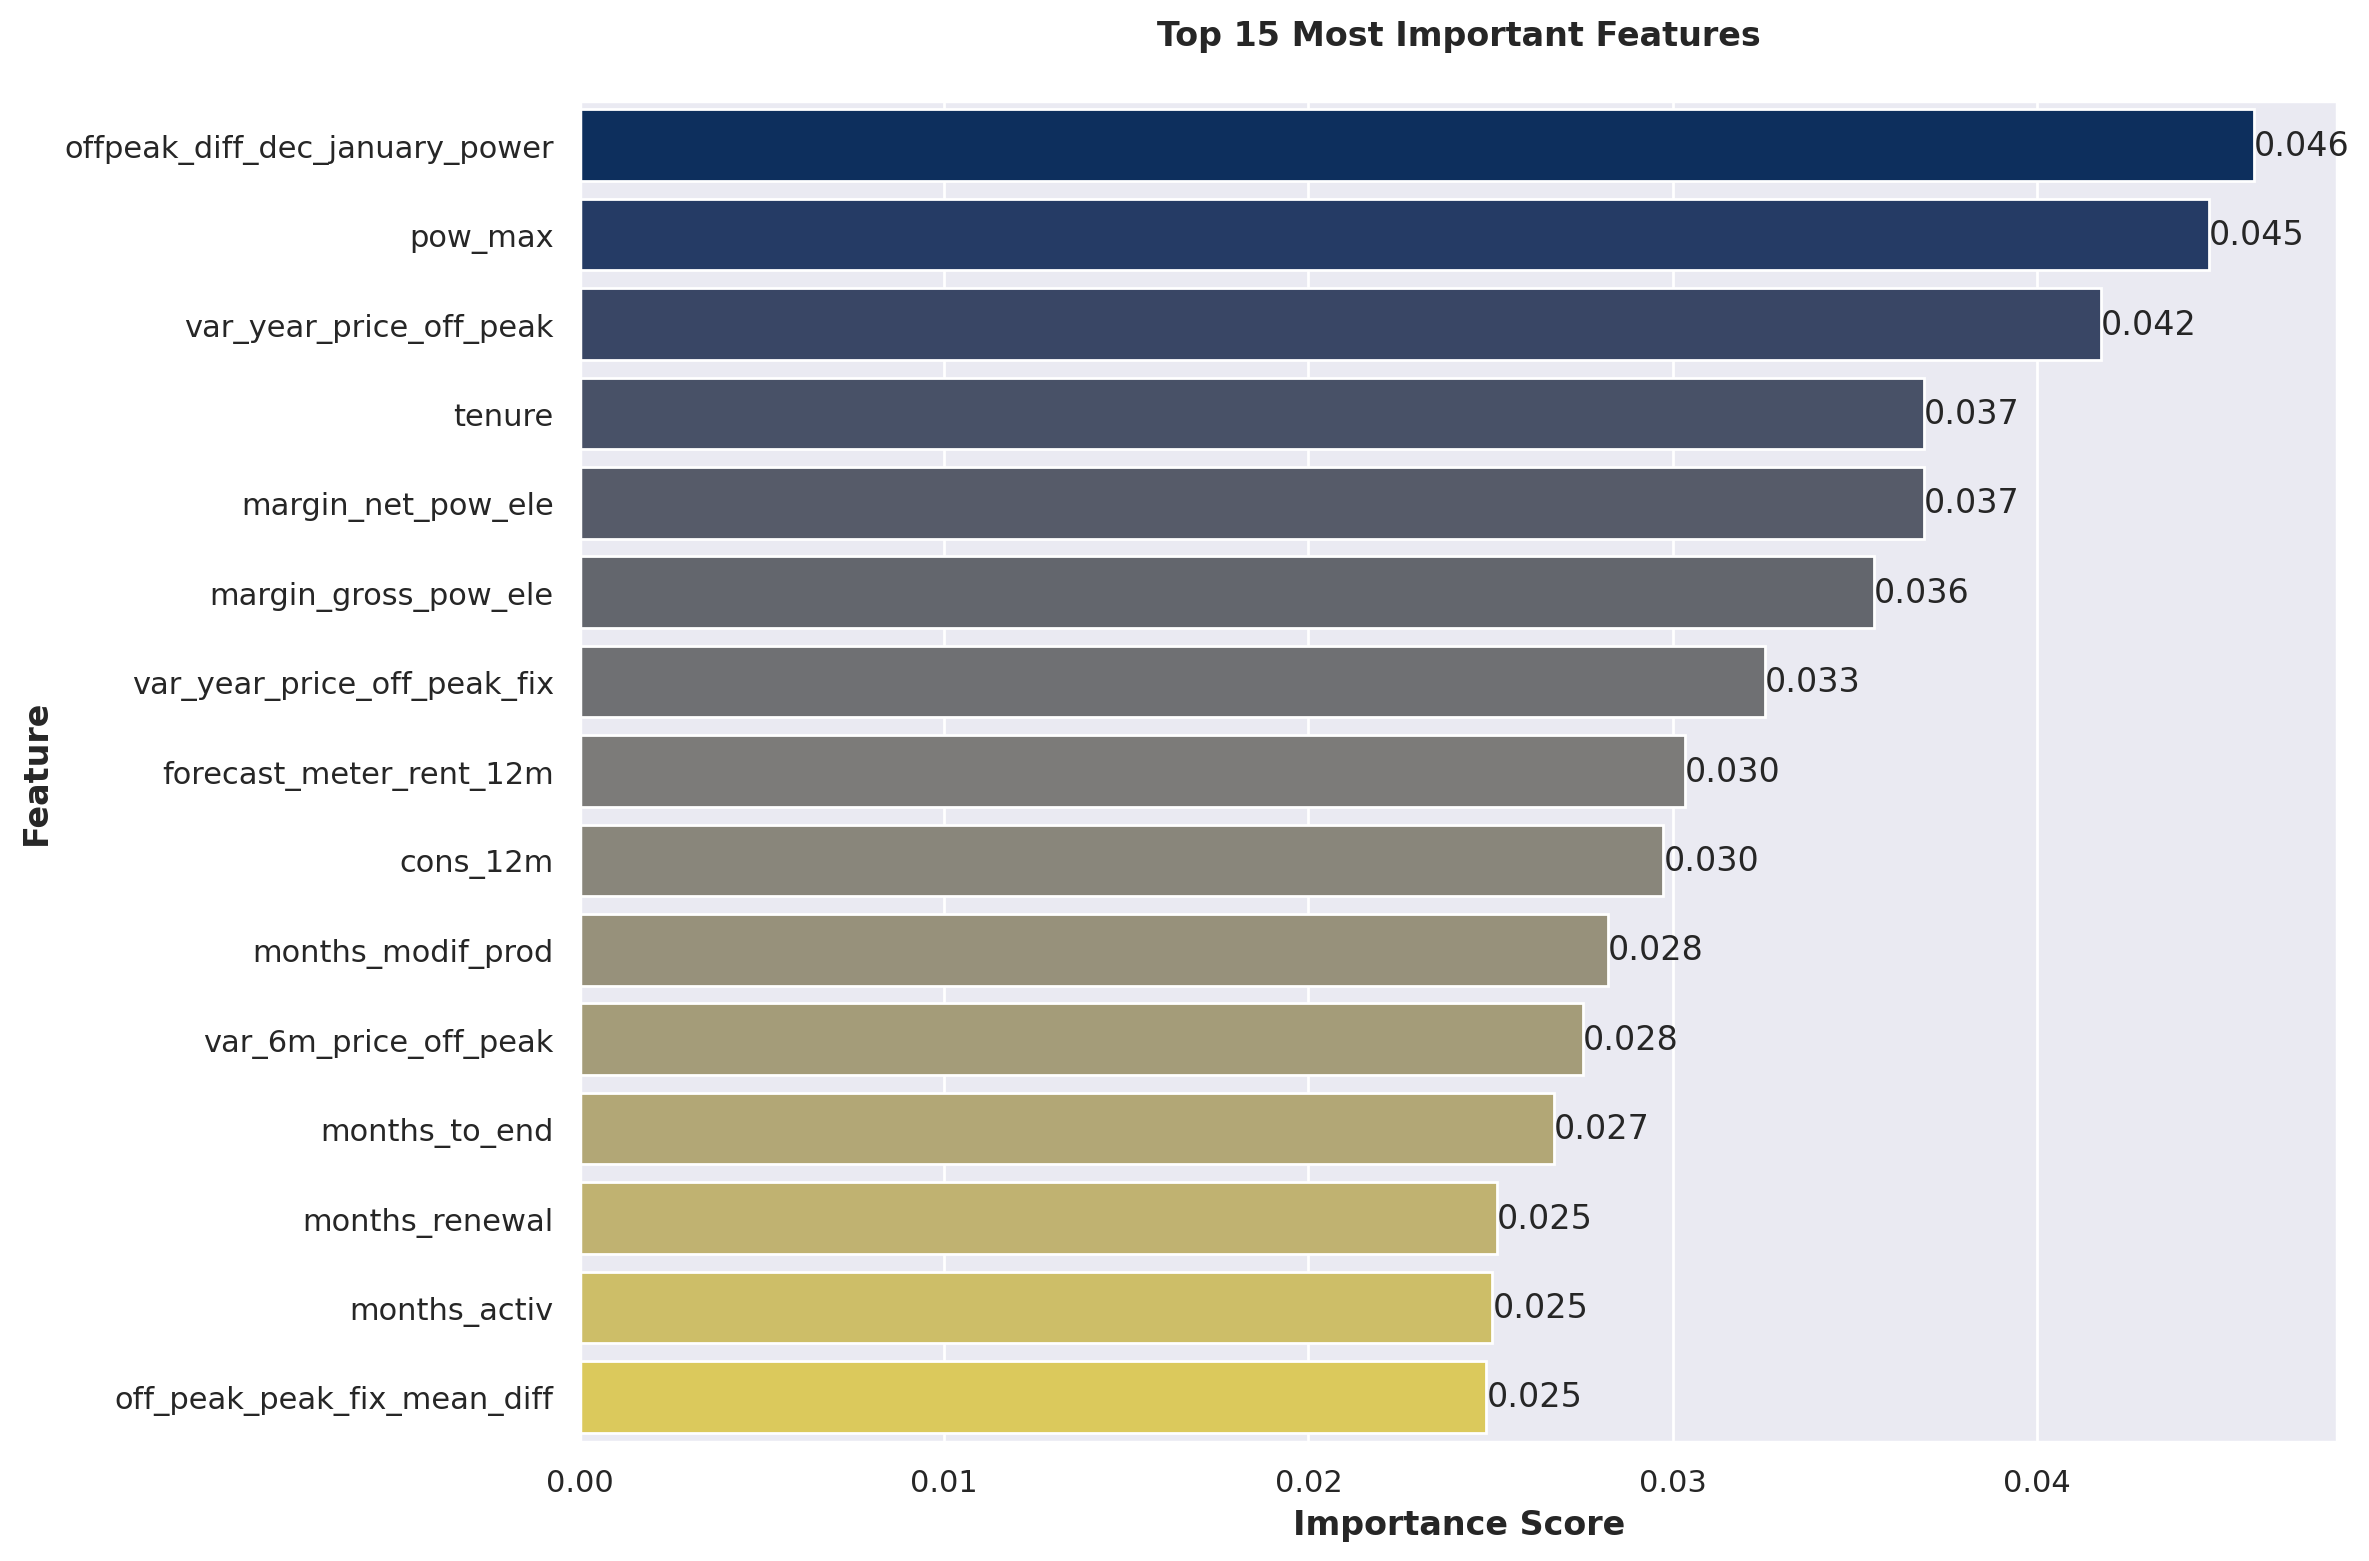

In [12]:
predictor_0.plt_feature_importance(top_n=15)



Here's my analysis of the results and recommendations for improvement:

### Current Performance Analysis

1. **Class Imbalance**:
   - The dataset is heavily imbalanced (train: 9890 non-churned vs 1064 churned)
   - While SMOTE helped balance the training data, the model still shows bias towards the majority class

2. **Model Performance**:
   - High accuracy (90.5%) is misleading due to class imbalance
   - Poor recall for churned customers (15.2%) - we're missing ~85% of actual churners
   - Low precision for churned predictions (54%) - about half of our churn predictions are false positives
   - ROC-AUC of 0.689 indicates mediocre discriminative ability

3. **Feature Importance**:
   - Top features are related to pricing and power usage
   - Temporal features (like `offpeak_diff_dec_january_power`) seem important
   - Customer relationship features (`tenure`) play a significant role

### Recommended Next Steps

1. **Model Improvements**:
   ```markdown
   - Try different sampling techniques:
     * ADASYN instead of SMOTE
     * Combination of undersampling and oversampling (SMOTETomek or SMOTENN)
   - Implement class weights instead of resampling
   - Experiment with other algorithms:
     * XGBoost or LightGBM (often perform better on imbalanced data)
     * Stacking with different base models
   ```

2. **Hyperparameter Optimization**:
   ```markdown
   - Implement GridSearchCV or RandomizedSearchCV for:
     * n_estimators
     * max_depth
     * min_samples_split
     * min_samples_leaf
     * class_weight
   - Use stratified k-fold CV to maintain class distribution
   ```


## Fine-tuning with _Optuna_

In [13]:
# Initialize and train model
predictor_1 = LightGBMChurnPredictor(
    sampling_method='adasyn',
    use_gpu = True
)
predictor_1

GPU is available and will be used for training


LightGBMChurnPredictor(sampling_method='adasyn')

In [14]:
# pipeline.train_final_model()    # Train the final model with the best parameters
# pipeline.evaluate_model()       # Evaluate the model on the test set
# pipeline.plot_confusion_matrix()  # Plot the confusion matrix
# pipeline.visualize_study()      # Visualize the study and model feature importances

In [15]:
predictor_1.train(df, n_trials=30)  # Run the optimization with 50 trials


[I 2024-12-12 16:09:40,403] A new study created in memory with name: no-name-b7a8f267-0e60-498c-a5d8-6680479f3614


[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


Please recompile with CMake option -DUSE_CUDA=1
Retrying with CPU...
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's binary_logloss: 0.32134
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.307208
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.320505
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.317203
Training until validation scores don't improve for 10 rounds


[I 2024-12-12 16:10:29,668] Trial 0 finished with value: 0.15207038974140819 and parameters: {'max_depth': 10, 'num_leaves': 21, 'min_child_samples': 9, 'learning_rate': 0.011271563690553271, 'feature_fraction': 0.43425709779683525, 'lambda_l1': 5.958919405747489e-05, 'lambda_l2': 1.1155666235540705e-05, 'max_bin': 303, 'min_data_in_bin': 31}. Best is trial 0 with value: 0.15207038974140819.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.305501
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[584]	valid_0's binary_logloss: 0.313551
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[434]	valid_0's binary_logloss: 0.299519
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[513]	valid_0's binary_logloss: 0.312113
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[501]	valid_0's binary_logloss: 0.310669
Training until validation scores don't improve for 10 rounds


[I 2024-12-12 16:10:55,448] Trial 1 finished with value: 0.1761438909195694 and parameters: {'max_depth': 5, 'num_leaves': 118, 'min_child_samples': 48, 'learning_rate': 0.04956421438421288, 'feature_fraction': 0.7087563781705044, 'lambda_l1': 9.960607775303975e-05, 'lambda_l2': 0.030552710082370187}. Best is trial 1 with value: 0.1761438909195694.


Early stopping, best iteration is:
[385]	valid_0's binary_logloss: 0.298172
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[255]	valid_0's binary_logloss: 0.308615
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[241]	valid_0's binary_logloss: 0.289396
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[256]	valid_0's binary_logloss: 0.302328
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[241]	valid_0's binary_logloss: 0.298337
Training until validation scores don't improve for 10 rounds


[I 2024-12-12 16:11:43,627] Trial 2 finished with value: 0.2095898535733458 and parameters: {'max_depth': 12, 'num_leaves': 147, 'min_child_samples': 35, 'learning_rate': 0.02718072715498817, 'feature_fraction': 0.4318012832265649, 'lambda_l1': 0.000268422675252588, 'lambda_l2': 0.00356660652451938}. Best is trial 2 with value: 0.2095898535733458.


Early stopping, best iteration is:
[274]	valid_0's binary_logloss: 0.289908
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[296]	valid_0's binary_logloss: 0.308349
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[257]	valid_0's binary_logloss: 0.295145
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[243]	valid_0's binary_logloss: 0.307934
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[211]	valid_0's binary_logloss: 0.306425
Training until validation scores don't improve for 10 rounds


[I 2024-12-12 16:12:32,914] Trial 3 finished with value: 0.20333789078216408 and parameters: {'max_depth': 8, 'num_leaves': 170, 'min_child_samples': 22, 'learning_rate': 0.048483264728622744, 'feature_fraction': 0.6698974368111985, 'lambda_l1': 0.00013401619815666218, 'lambda_l2': 0.27211505425375476}. Best is trial 2 with value: 0.2095898535733458.


Early stopping, best iteration is:
[248]	valid_0's binary_logloss: 0.292935
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.404958
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.384211
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.404593
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.397801
Training until validation scores don't improve for 10 rounds


[I 2024-12-12 16:13:33,318] Trial 4 finished with value: 0.17161656860189037 and parameters: {'max_depth': 3, 'num_leaves': 64, 'min_child_samples': 79, 'learning_rate': 0.012699756072363214, 'feature_fraction': 0.7514031574743374, 'lambda_l1': 1.0332811583093027e-06, 'lambda_l2': 1.917490342578145e-08}. Best is trial 2 with value: 0.2095898535733458.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.37959
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[573]	valid_0's binary_logloss: 0.317717
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[672]	valid_0's binary_logloss: 0.297136
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[817]	valid_0's binary_logloss: 0.307431
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[674]	valid_0's binary_logloss: 0.312118
Training until validation scores don't improve for 10 rounds


[I 2024-12-12 16:14:13,208] Trial 5 finished with value: 0.17338717288864228 and parameters: {'max_depth': 4, 'num_leaves': 29, 'min_child_samples': 37, 'learning_rate': 0.054528650450299615, 'feature_fraction': 0.4784894623321084, 'lambda_l1': 0.43959828755902103, 'lambda_l2': 1.4218526879709542e-08}. Best is trial 2 with value: 0.2095898535733458.


Early stopping, best iteration is:
[700]	valid_0's binary_logloss: 0.297601
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.309186
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[977]	valid_0's binary_logloss: 0.292465
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.307151
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[967]	valid_0's binary_logloss: 0.305726
Training until validation scores don't improve for 10 rounds


[I 2024-12-12 16:15:47,005] Trial 6 finished with value: 0.19770235340580553 and parameters: {'max_depth': 8, 'num_leaves': 82, 'min_child_samples': 92, 'learning_rate': 0.013975781498604843, 'feature_fraction': 0.5504135007362222, 'lambda_l1': 3.501450081921878e-08, 'lambda_l2': 0.1650587896728149}. Best is trial 2 with value: 0.2095898535733458.


Early stopping, best iteration is:
[811]	valid_0's binary_logloss: 0.298188
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[190]	valid_0's binary_logloss: 0.308926
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[207]	valid_0's binary_logloss: 0.294336
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[196]	valid_0's binary_logloss: 0.302381
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[184]	valid_0's binary_logloss: 0.306792
Training until validation scores don't improve for 10 rounds


[I 2024-12-12 16:16:20,059] Trial 7 finished with value: 0.2288384553508235 and parameters: {'max_depth': 9, 'num_leaves': 36, 'min_child_samples': 54, 'learning_rate': 0.07738161732624076, 'feature_fraction': 0.6197336631099722, 'lambda_l1': 3.69182270098193e-07, 'lambda_l2': 1.011129349970425e-08}. Best is trial 7 with value: 0.2288384553508235.


Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.291476
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[388]	valid_0's binary_logloss: 0.310471
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[399]	valid_0's binary_logloss: 0.291635
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[393]	valid_0's binary_logloss: 0.306418
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[416]	valid_0's binary_logloss: 0.304719
Training until validation scores don't improve for 10 rounds


[I 2024-12-12 16:17:46,040] Trial 8 finished with value: 0.2097521155139317 and parameters: {'max_depth': 7, 'num_leaves': 116, 'min_child_samples': 74, 'learning_rate': 0.044570751681121755, 'feature_fraction': 0.4929250198284382, 'lambda_l1': 3.102204846386601e-06, 'lambda_l2': 1.422172128176946e-06}. Best is trial 7 with value: 0.2288384553508235.


Early stopping, best iteration is:
[394]	valid_0's binary_logloss: 0.29325
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[914]	valid_0's binary_logloss: 0.310376
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[848]	valid_0's binary_logloss: 0.293009
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.304445
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[976]	valid_0's binary_logloss: 0.300338
Training until validation scores don't improve for 10 rounds


[I 2024-12-12 16:20:46,256] Trial 9 finished with value: 0.2141197088061635 and parameters: {'max_depth': 9, 'num_leaves': 74, 'min_child_samples': 33, 'learning_rate': 0.01099820411425274, 'feature_fraction': 0.6706530860371165, 'lambda_l1': 0.09722787472591242, 'lambda_l2': 1.2637016109284965e-05}. Best is trial 7 with value: 0.2288384553508235.


Did not meet early stopping. Best iteration is:
[995]	valid_0's binary_logloss: 0.2893
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.311251
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[94]	valid_0's binary_logloss: 0.291672
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.310787
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.308828
Training until validation scores don't improve for 10 rounds


[I 2024-12-12 16:21:17,434] Trial 10 finished with value: 0.22947788406995132 and parameters: {'max_depth': 12, 'num_leaves': 255, 'min_child_samples': 64, 'learning_rate': 0.09805459544836817, 'feature_fraction': 0.9374548031593336, 'lambda_l1': 1.7423530581993063e-08, 'lambda_l2': 0.00019562107283633296}. Best is trial 10 with value: 0.22947788406995132.


Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.297036
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.317368
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.300229
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.307445
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.304057
Training until validation scores don't improve for 10 rounds


[I 2024-12-12 16:21:35,050] Trial 11 finished with value: 0.2292573595084486 and parameters: {'max_depth': 12, 'num_leaves': 251, 'min_child_samples': 62, 'learning_rate': 0.09822784388213208, 'feature_fraction': 0.9950559413438571, 'lambda_l1': 2.5861939279889687e-08, 'lambda_l2': 0.000290272472583489}. Best is trial 10 with value: 0.22947788406995132.


Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.294862
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[138]	valid_0's binary_logloss: 0.310435
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.294609
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[139]	valid_0's binary_logloss: 0.303849
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[129]	valid_0's binary_logloss: 0.295008
Training until validation scores don't improve for 10 rounds


[I 2024-12-12 16:21:57,066] Trial 12 finished with value: 0.2250376670150708 and parameters: {'max_depth': 12, 'num_leaves': 256, 'min_child_samples': 65, 'learning_rate': 0.09964546500540607, 'feature_fraction': 0.9961618552545819, 'lambda_l1': 1.1587065664682003e-08, 'lambda_l2': 8.462989313228027}. Best is trial 10 with value: 0.22947788406995132.


Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.296318
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[123]	valid_0's binary_logloss: 0.313669
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.293464
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[114]	valid_0's binary_logloss: 0.307822
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.304956
Training until validation scores don't improve for 10 rounds


[I 2024-12-12 16:22:17,511] Trial 13 finished with value: 0.21210195379944952 and parameters: {'max_depth': 11, 'num_leaves': 254, 'min_child_samples': 100, 'learning_rate': 0.09956733389363467, 'feature_fraction': 0.9980552350391945, 'lambda_l1': 0.013187016165621764, 'lambda_l2': 0.0004039217146349711}. Best is trial 10 with value: 0.22947788406995132.


Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.297694
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[498]	valid_0's binary_logloss: 0.306682
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[470]	valid_0's binary_logloss: 0.296454
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[550]	valid_0's binary_logloss: 0.306422
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[503]	valid_0's binary_logloss: 0.298015
Training until validation scores don't improve for 10 rounds


[I 2024-12-12 16:23:29,394] Trial 14 finished with value: 0.21047679702227523 and parameters: {'max_depth': 11, 'num_leaves': 211, 'min_child_samples': 60, 'learning_rate': 0.02802502237522863, 'feature_fraction': 0.8721042689374103, 'lambda_l1': 7.236611248587967, 'lambda_l2': 0.00023653305269462406}. Best is trial 10 with value: 0.22947788406995132.


Early stopping, best iteration is:
[439]	valid_0's binary_logloss: 0.29761
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.310093
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[144]	valid_0's binary_logloss: 0.293478
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[114]	valid_0's binary_logloss: 0.309235
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.302857
Training until validation scores don't improve for 10 rounds


[I 2024-12-12 16:23:54,555] Trial 15 finished with value: 0.22450270732028552 and parameters: {'max_depth': 12, 'num_leaves': 211, 'min_child_samples': 74, 'learning_rate': 0.07001994451733513, 'feature_fraction': 0.8781522866813692, 'lambda_l1': 1.1034688306078671e-07, 'lambda_l2': 0.0001694398571414169}. Best is trial 10 with value: 0.22947788406995132.


Early stopping, best iteration is:
[143]	valid_0's binary_logloss: 0.294197
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.315538
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[989]	valid_0's binary_logloss: 0.296713
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's binary_logloss: 0.313928
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's binary_logloss: 0.311237
Training until validation scores don't improve for 10 rounds


[I 2024-12-12 16:24:57,357] Trial 16 finished with value: 0.18410635842977627 and parameters: {'max_depth': 6, 'num_leaves': 218, 'min_child_samples': 84, 'learning_rate': 0.01772270587203373, 'feature_fraction': 0.8955807628629852, 'lambda_l1': 2.731689555212012e-06, 'lambda_l2': 8.907891093336697e-07}. Best is trial 10 with value: 0.22947788406995132.


Did not meet early stopping. Best iteration is:
[993]	valid_0's binary_logloss: 0.301171
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[138]	valid_0's binary_logloss: 0.31145
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[139]	valid_0's binary_logloss: 0.294119
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[156]	valid_0's binary_logloss: 0.311297
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.30383
Training until validation scores don't improve for 10 rounds


[I 2024-12-12 16:25:30,638] Trial 17 finished with value: 0.20736587960553451 and parameters: {'max_depth': 10, 'num_leaves': 182, 'min_child_samples': 46, 'learning_rate': 0.06889497759117351, 'feature_fraction': 0.8032098053394536, 'lambda_l1': 9.659955999984232e-06, 'lambda_l2': 0.0024734302410521825}. Best is trial 10 with value: 0.22947788406995132.


Early stopping, best iteration is:
[135]	valid_0's binary_logloss: 0.292247
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[315]	valid_0's binary_logloss: 0.309865
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[319]	valid_0's binary_logloss: 0.295356
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[349]	valid_0's binary_logloss: 0.304214
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[337]	valid_0's binary_logloss: 0.302447
Training until validation scores don't improve for 10 rounds


[I 2024-12-12 16:26:29,408] Trial 18 finished with value: 0.2305059064611251 and parameters: {'max_depth': 10, 'num_leaves': 233, 'min_child_samples': 65, 'learning_rate': 0.032661553889274934, 'feature_fraction': 0.9341396672413463, 'lambda_l1': 0.0018370455186019353, 'lambda_l2': 2.826314760193794e-05}. Best is trial 18 with value: 0.2305059064611251.


Early stopping, best iteration is:
[307]	valid_0's binary_logloss: 0.293681
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[447]	valid_0's binary_logloss: 0.310017
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[489]	valid_0's binary_logloss: 0.293632
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[480]	valid_0's binary_logloss: 0.307149
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[468]	valid_0's binary_logloss: 0.302023
Training until validation scores don't improve for 10 rounds


[I 2024-12-12 16:27:50,144] Trial 19 finished with value: 0.22578657256108864 and parameters: {'max_depth': 10, 'num_leaves': 226, 'min_child_samples': 67, 'learning_rate': 0.021024034394040308, 'feature_fraction': 0.9260331628402427, 'lambda_l1': 0.003786068192270476, 'lambda_l2': 1.4034603584083906e-05}. Best is trial 18 with value: 0.2305059064611251.


Early stopping, best iteration is:
[501]	valid_0's binary_logloss: 0.292556
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[286]	valid_0's binary_logloss: 0.308366
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[289]	valid_0's binary_logloss: 0.29119
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[300]	valid_0's binary_logloss: 0.305478
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[290]	valid_0's binary_logloss: 0.300339
Training until validation scores don't improve for 10 rounds


[I 2024-12-12 16:28:32,598] Trial 20 finished with value: 0.2179220312040704 and parameters: {'max_depth': 11, 'num_leaves': 176, 'min_child_samples': 88, 'learning_rate': 0.03684080332193113, 'feature_fraction': 0.7969837530477474, 'lambda_l1': 0.005586972764594367, 'lambda_l2': 2.684555591559667e-07}. Best is trial 18 with value: 0.2305059064611251.


Early stopping, best iteration is:
[255]	valid_0's binary_logloss: 0.291821
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[93]	valid_0's binary_logloss: 0.313522
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[103]	valid_0's binary_logloss: 0.298766
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[106]	valid_0's binary_logloss: 0.309761
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.302467
Training until validation scores don't improve for 10 rounds


[I 2024-12-12 16:28:55,868] Trial 21 finished with value: 0.21042352923978563 and parameters: {'max_depth': 12, 'num_leaves': 236, 'min_child_samples': 56, 'learning_rate': 0.08139496405124948, 'feature_fraction': 0.9446927327604766, 'lambda_l1': 1.1207495085520533e-07, 'lambda_l2': 4.2733427227410234e-05}. Best is trial 18 with value: 0.2305059064611251.


Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.292869
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[132]	valid_0's binary_logloss: 0.310011
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[181]	valid_0's binary_logloss: 0.292635
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[140]	valid_0's binary_logloss: 0.307567
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[147]	valid_0's binary_logloss: 0.303195
Training until validation scores don't improve for 10 rounds


[I 2024-12-12 16:29:19,500] Trial 22 finished with value: 0.223561374263359 and parameters: {'max_depth': 11, 'num_leaves': 196, 'min_child_samples': 67, 'learning_rate': 0.06089128013675207, 'feature_fraction': 0.8292300815042064, 'lambda_l1': 1.0507873231615098e-08, 'lambda_l2': 0.001844989573788587}. Best is trial 18 with value: 0.2305059064611251.


Early stopping, best iteration is:
[112]	valid_0's binary_logloss: 0.294726
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[307]	valid_0's binary_logloss: 0.314279
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[264]	valid_0's binary_logloss: 0.297782
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[275]	valid_0's binary_logloss: 0.306871
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[322]	valid_0's binary_logloss: 0.303248
Training until validation scores don't improve for 10 rounds


[I 2024-12-12 16:30:03,565] Trial 23 finished with value: 0.21960626221332333 and parameters: {'max_depth': 9, 'num_leaves': 240, 'min_child_samples': 44, 'learning_rate': 0.03898716472200088, 'feature_fraction': 0.9531739611678927, 'lambda_l1': 1.6082990030449426e-05, 'lambda_l2': 0.014904147311066929}. Best is trial 18 with value: 0.2305059064611251.


Early stopping, best iteration is:
[273]	valid_0's binary_logloss: 0.290269
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[114]	valid_0's binary_logloss: 0.310504
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.294245
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[114]	valid_0's binary_logloss: 0.310955
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.30501
Training until validation scores don't improve for 10 rounds


[I 2024-12-12 16:30:20,977] Trial 24 finished with value: 0.229088207842914 and parameters: {'max_depth': 10, 'num_leaves': 239, 'min_child_samples': 61, 'learning_rate': 0.08629185846312444, 'feature_fraction': 0.8492669101536576, 'lambda_l1': 0.0013776472605760994, 'lambda_l2': 3.972330349431718e-05}. Best is trial 18 with value: 0.2305059064611251.


Early stopping, best iteration is:
[116]	valid_0's binary_logloss: 0.293072
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[450]	valid_0's binary_logloss: 0.306135
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[409]	valid_0's binary_logloss: 0.293558
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[470]	valid_0's binary_logloss: 0.30367
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[303]	valid_0's binary_logloss: 0.305187
Training until validation scores don't improve for 10 rounds


[I 2024-12-12 16:32:48,456] Trial 25 finished with value: 0.22885380089914809 and parameters: {'max_depth': 12, 'num_leaves': 198, 'min_child_samples': 73, 'learning_rate': 0.022344238191661335, 'feature_fraction': 0.9531680632787338, 'lambda_l1': 0.04933113926092437, 'lambda_l2': 2.5109665375318734e-06}. Best is trial 18 with value: 0.2305059064611251.


Early stopping, best iteration is:
[368]	valid_0's binary_logloss: 0.295234
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.311391
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.296156
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[156]	valid_0's binary_logloss: 0.307167
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[147]	valid_0's binary_logloss: 0.303057
Training until validation scores don't improve for 10 rounds


[I 2024-12-12 16:33:21,671] Trial 26 finished with value: 0.222702629526173 and parameters: {'max_depth': 11, 'num_leaves': 150, 'min_child_samples': 53, 'learning_rate': 0.05963913835546207, 'feature_fraction': 0.9193840290472856, 'lambda_l1': 2.150149996275413e-07, 'lambda_l2': 0.00043999031423313194}. Best is trial 18 with value: 0.2305059064611251.


Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.293891
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[277]	valid_0's binary_logloss: 0.310133
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[253]	valid_0's binary_logloss: 0.292302
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[278]	valid_0's binary_logloss: 0.309285
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[294]	valid_0's binary_logloss: 0.302531
Training until validation scores don't improve for 10 rounds


[I 2024-12-12 16:34:11,910] Trial 27 finished with value: 0.2336590282387662 and parameters: {'max_depth': 11, 'num_leaves': 253, 'min_child_samples': 79, 'learning_rate': 0.03488389838637411, 'feature_fraction': 0.9984328463052339, 'lambda_l1': 2.194600757785265e-05, 'lambda_l2': 1.6623769618005635e-07}. Best is trial 27 with value: 0.2336590282387662.


Early stopping, best iteration is:
[288]	valid_0's binary_logloss: 0.295724
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[468]	valid_0's binary_logloss: 0.310435
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[498]	valid_0's binary_logloss: 0.296909
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[489]	valid_0's binary_logloss: 0.306685
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[446]	valid_0's binary_logloss: 0.306171
Training until validation scores don't improve for 10 rounds


[I 2024-12-12 16:34:52,278] Trial 28 finished with value: 0.19113939077555575 and parameters: {'max_depth': 7, 'num_leaves': 194, 'min_child_samples': 82, 'learning_rate': 0.03319109260494421, 'feature_fraction': 0.7679567047126815, 'lambda_l1': 0.0006640423935917967, 'lambda_l2': 1.8258172920705218e-07}. Best is trial 27 with value: 0.2336590282387662.


Early stopping, best iteration is:
[483]	valid_0's binary_logloss: 0.294982
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[489]	valid_0's binary_logloss: 0.307648
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[385]	valid_0's binary_logloss: 0.296122
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[436]	valid_0's binary_logloss: 0.307858
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[441]	valid_0's binary_logloss: 0.301809
Training until validation scores don't improve for 10 rounds


[I 2024-12-12 16:35:55,752] Trial 29 finished with value: 0.22524117137638672 and parameters: {'max_depth': 10, 'num_leaves': 229, 'min_child_samples': 97, 'learning_rate': 0.02709668747991471, 'feature_fraction': 0.9044431646617437, 'lambda_l1': 2.312027696338586e-05, 'lambda_l2': 1.2846506075154805e-07}. Best is trial 27 with value: 0.2336590282387662.


Early stopping, best iteration is:
[374]	valid_0's binary_logloss: 0.297324


{'best_params': {'objective': 'binary',
  'metric': 'binary_logloss',
  'verbosity': -1,
  'boosting_type': 'gbdt',
  'deterministic': True,
  'max_depth': 11,
  'num_leaves': 253,
  'min_child_samples': 79,
  'learning_rate': 0.03488389838637411,
  'feature_fraction': 0.9984328463052339,
  'lambda_l1': 2.194600757785265e-05,
  'lambda_l2': 1.6623769618005635e-07,
  'num_boost_round': 1000},
 'best_score': 0.2336590282387662,
 'optimization_history':     number     value             datetime_start          datetime_complete  \
 0        0  0.152070 2024-12-12 16:09:40.404498 2024-12-12 16:10:29.667665   
 1        1  0.176144 2024-12-12 16:10:29.671025 2024-12-12 16:10:55.447754   
 2        2  0.209590 2024-12-12 16:10:55.449122 2024-12-12 16:11:43.627349   
 3        3  0.203338 2024-12-12 16:11:43.628453 2024-12-12 16:12:32.913669   
 4        4  0.171617 2024-12-12 16:12:32.916272 2024-12-12 16:13:33.318307   
 5        5  0.173387 2024-12-12 16:13:33.320694 2024-12-12 16:14:13.208

In [16]:
test_results = predictor_1.evaluate()

In [17]:
print("Classification Report:")
print(pd.DataFrame(test_results['classification_report']).transpose())

print("\nConfusion Matrix:")
print(np.array(test_results['confusion_matrix']))

print(f"\nROC-AUC Score: {test_results['roc_auc']:.3f}")

print("\nClass Distribution:")
print("Original Training Set:", test_results['class_distribution']['train'])
print("Test Set:", test_results['class_distribution']['test'])


Classification Report:
              precision    recall  f1-score     support
0              0.921930  0.984837  0.952346  2638.00000
1              0.615385  0.225352  0.329897   284.00000
accuracy       0.911020  0.911020  0.911020     0.91102
macro avg      0.768658  0.605095  0.641121  2922.00000
weighted avg   0.892136  0.911020  0.891848  2922.00000

Confusion Matrix:
[[2598   40]
 [ 220   64]]

ROC-AUC Score: 0.711

Class Distribution:
Original Training Set: {0: 10549, 1: 1135}
Test Set: {0: 2638, 1: 284}


In [18]:
predictor_1.plot_optimization_history()  # Train the final model with the best parameters


In [19]:
predictor_1.plot_param_importances()

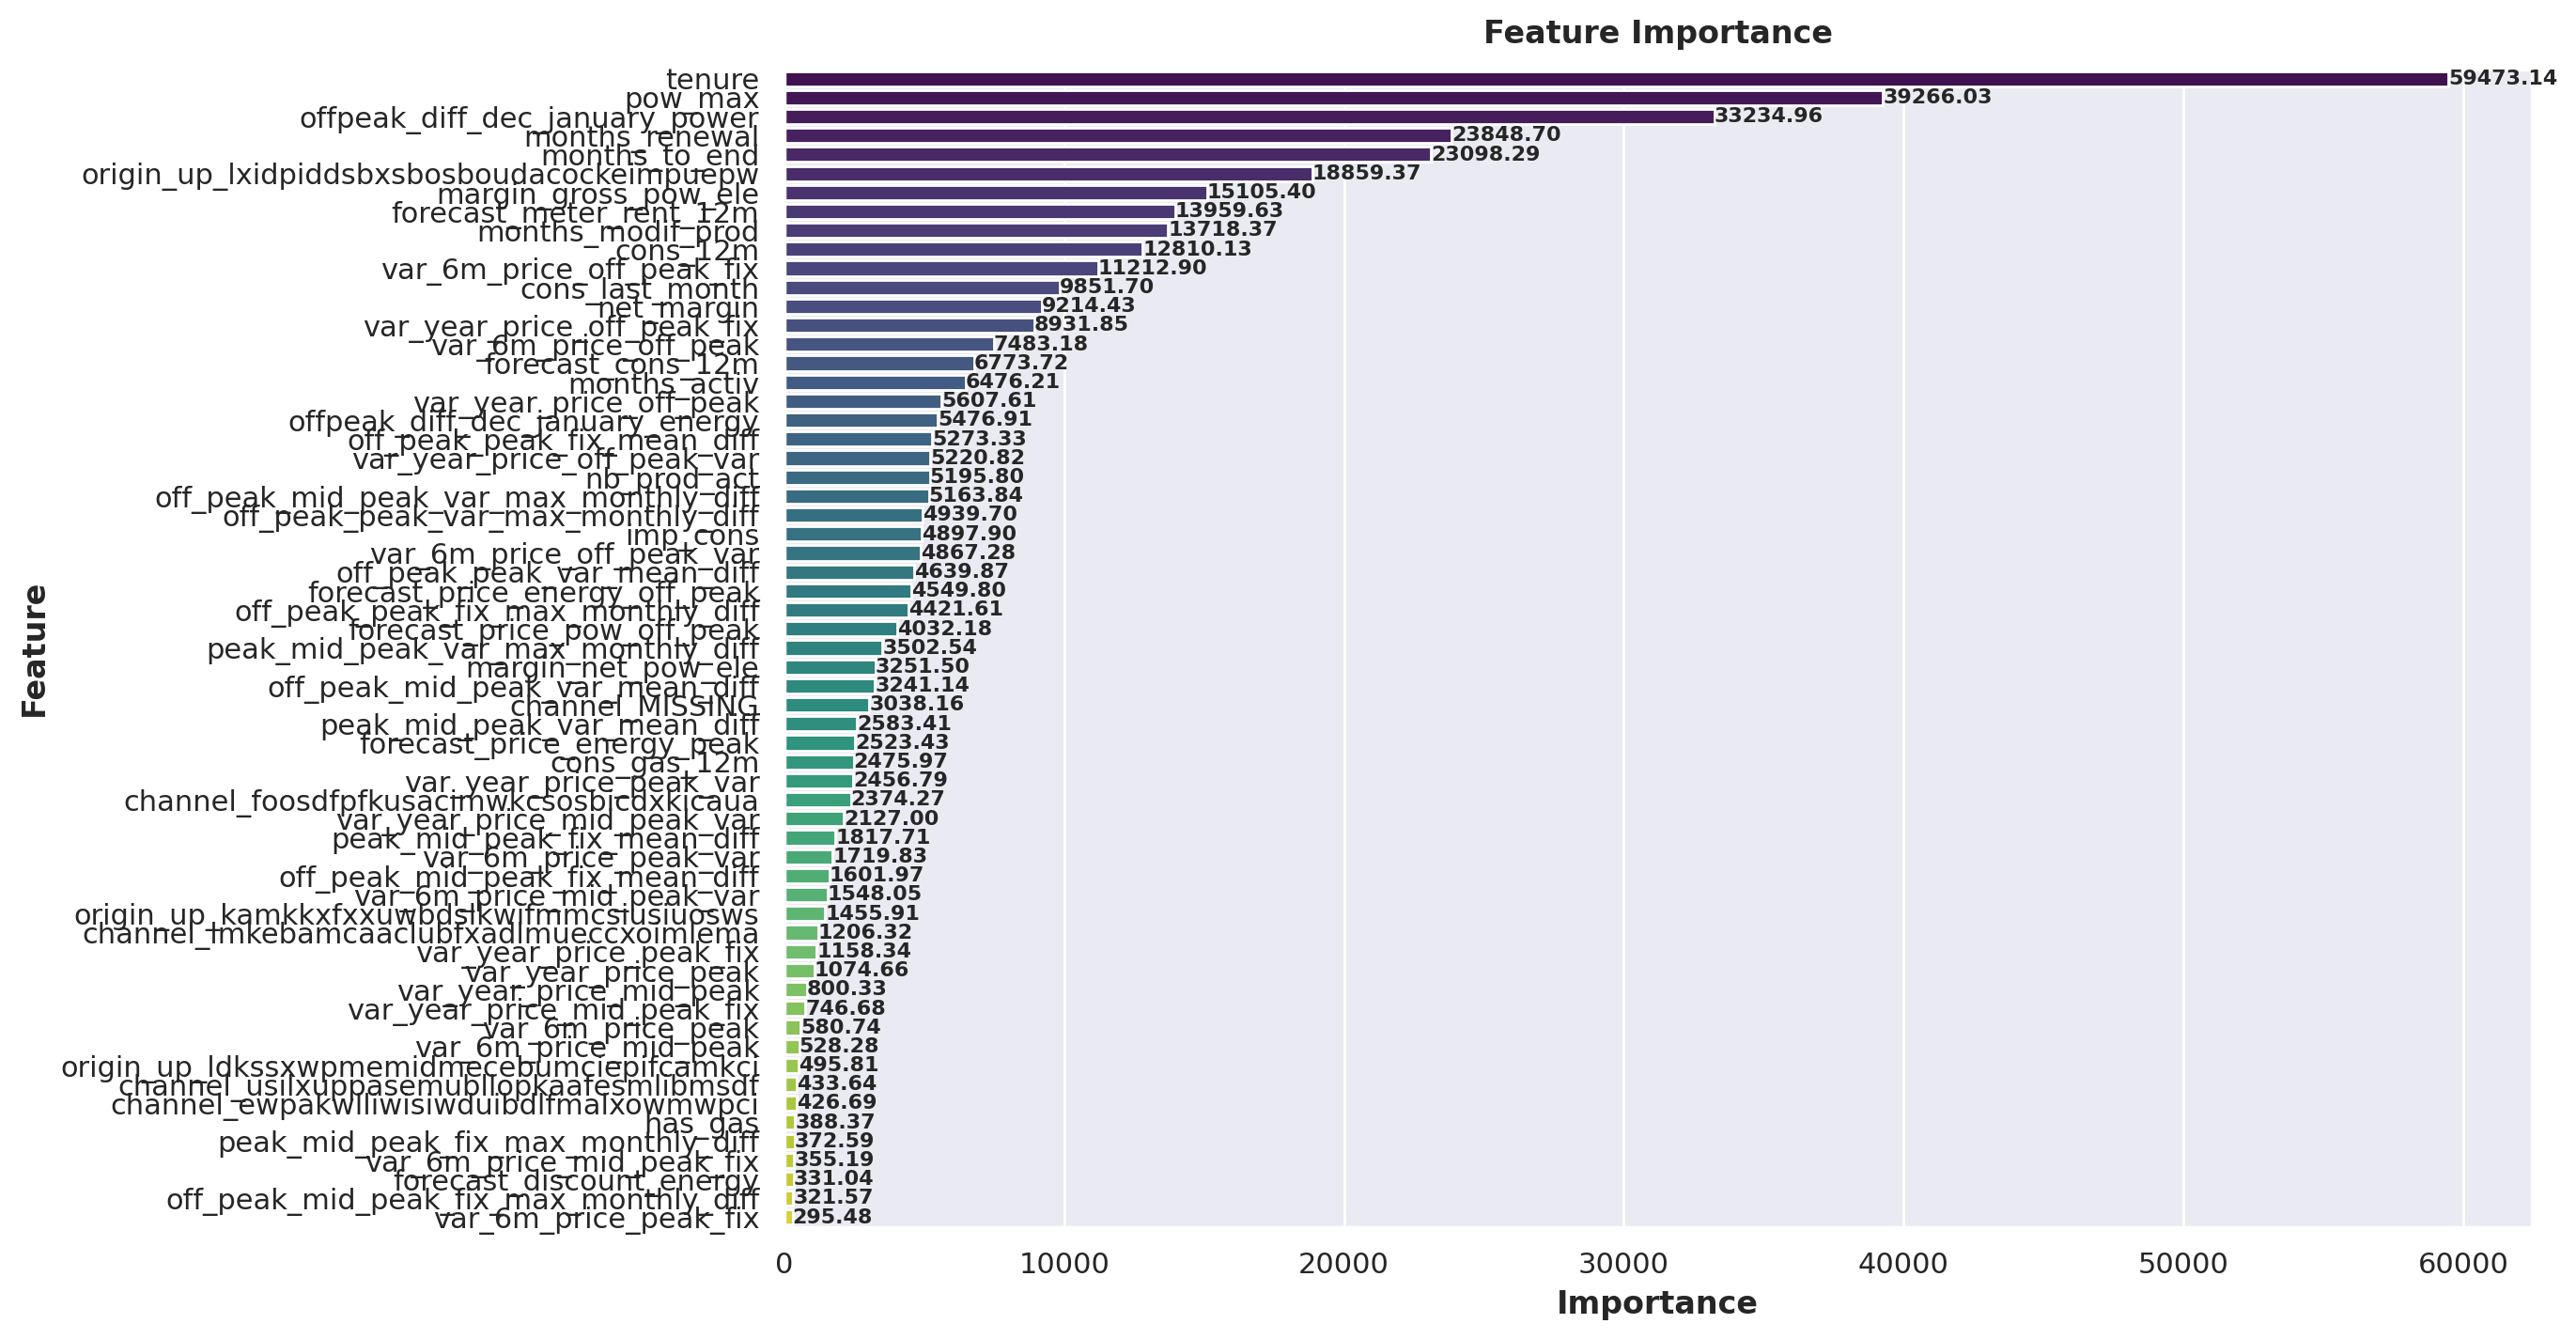

In [20]:
predictor_1.plot_feature_importance()

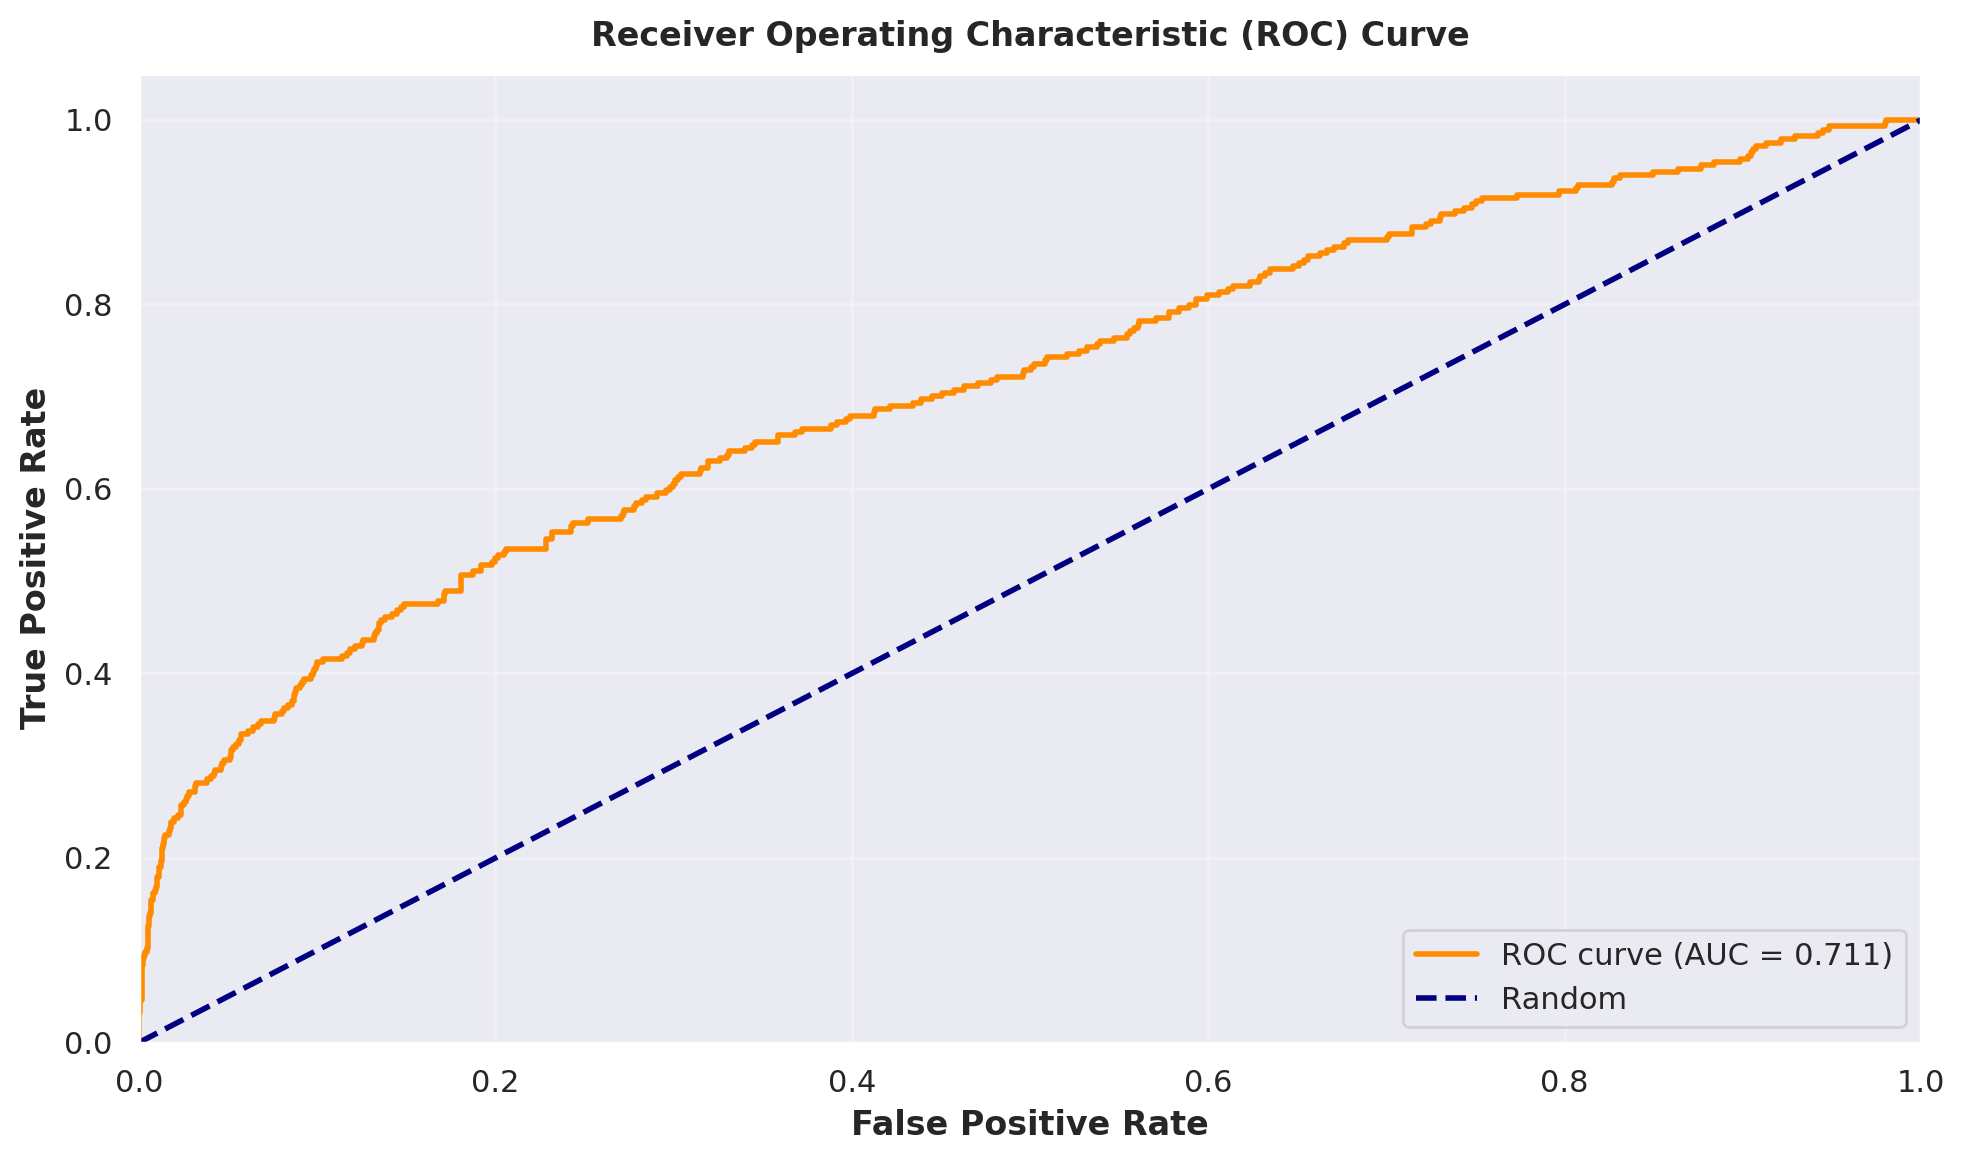

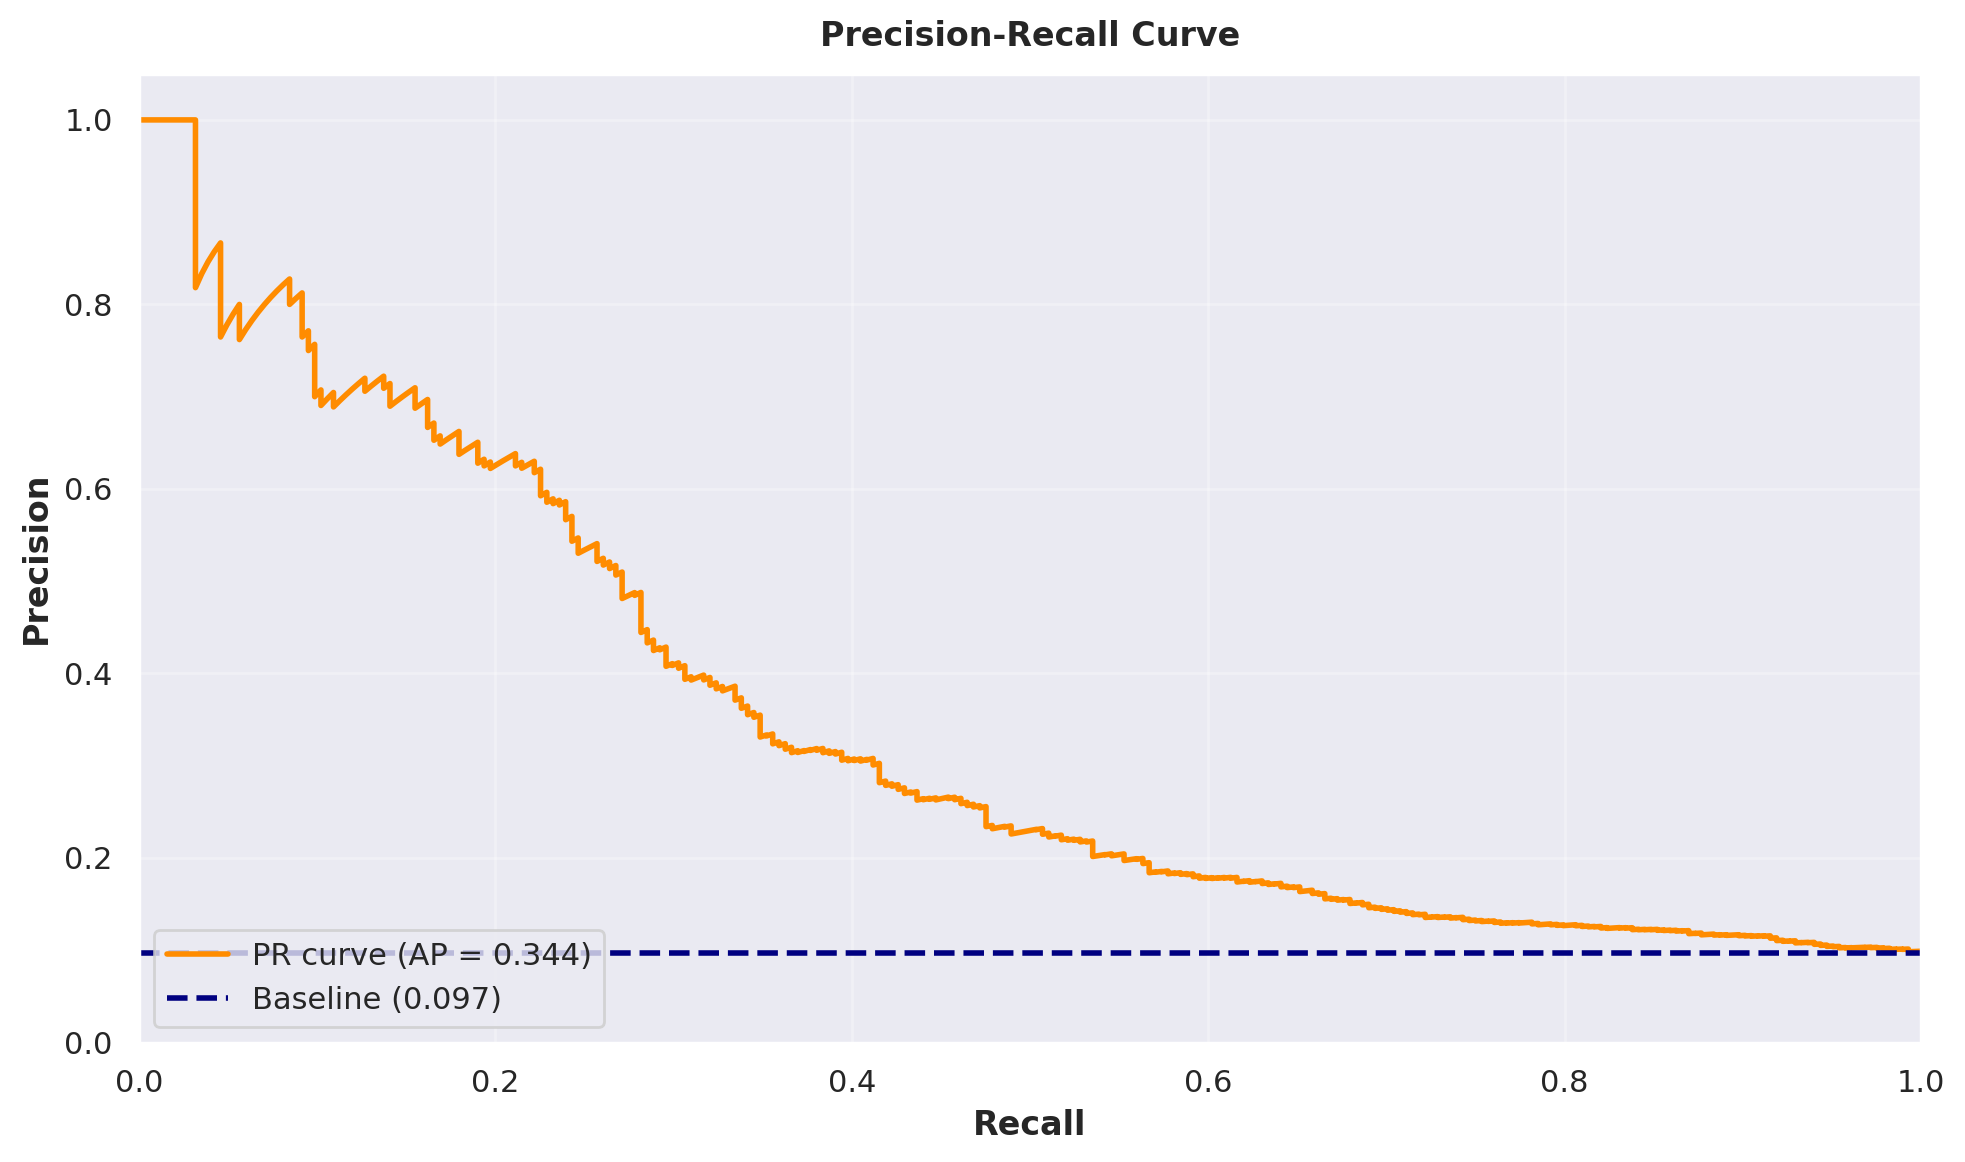

In [21]:
# Plot ROC curve
roc_fig = predictor_1.plot_roc_curve(figsize=(10, 6))
# roc_fig.savefig('roc_curve.png')  # optional: save the plot

# Plot Precision-Recall curve
pr_fig = predictor_1.plot_precision_recall_curve(figsize=(10, 6))
# pr_fig.savefig('pr_curve.png')  # optional: save the plot

*OpenAI is experiencing a partial outage right now. To avoid downtime, we've temporarily fallen back to an Anthropic model.*



Let's compare the key metrics:

**New Results vs Previous Results:**
1. **Precision (Class 1)**:
   - New: 0.615 vs Old: 0.540
   - ✅ Better: Higher precision means fewer false positives

2. **Recall (Class 1)**:
   - New: 0.225 vs Old: 0.152
   - ✅ Better: Higher recall means we're catching more actual churners

3. **F1-Score (Class 1)**:
   - New: 0.330 vs Old: 0.237
   - ✅ Better: Better balance between precision and recall

4. **ROC-AUC**:
   - New: 0.711 vs Old: 0.689
   - ✅ Better: Improved overall discriminative ability

5. **Confusion Matrix Analysis**:
   - New: 64 true positives, 40 false positives
   - Old: 54 true positives, 46 false positives
   - ✅ Better: More true positives and fewer false positives

**Verdict**: The new results are better across all important metrics, particularly for the minority class (churners). However, there's still room for improvement, especially in recall (0.225 means we're still missing ~77.5% of actual churners).
